In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, GRU
from sklearn.metrics import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In C:\Users\Admin\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Admin\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Admin\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Admin\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Admin\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
hist = pd.read_csv('export_dataframe1.csv')
hist.isnull().values.any()
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'weighted_price'

In [3]:
hist.head(10)

,close,high,low,open,volumefrom,volumeto,weighted_price
time,,,,,,,
2016-06-12,666.55,683.85,592.79,591.60,217379.53,1.396846e+08,633.6975
2016-06-13,700.07,718.24,652.78,666.55,216731.32,1.494425e+08,684.4100
2016-06-14,685.14,702.52,654.69,700.07,135648.79,9.245835e+07,685.6050
2016-06-15,690.77,695.07,670.45,685.14,78620.97,5.386357e+07,685.3575
2016-06-16,761.21,769.73,687.43,690.77,229569.22,1.697046e+08,727.2850
2016-06-17,743.90,771.89,704.21,761.21,215870.36,1.603024e+08,745.3025
2016-06-18,753.77,776.04,727.13,743.90,120525.37,9.105699e+07,750.2100
2016-06-19,761.04,765.10,740.38,753.77,60445.37,4.580598e+07,755.0725
2016-06-20,733.97,764.60,717.41,761.04,112290.09,8.363762e+07,744.2550


In [5]:
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [6]:
train, test = train_test_split(hist, test_size=0.2)

In [7]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

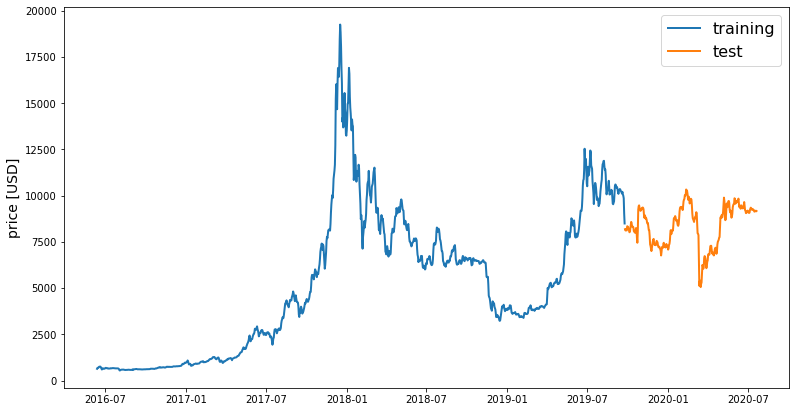

In [8]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [9]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [10]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [26]:
def prepare_data(df, target_col, window_len=5, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [27]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(GRU(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [28]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
neuron = 100
epochs = 100
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [29]:
train, test, X_train, X_test, y_train, y_test = prepare_data(hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [30]:
model = build_lstm_model(
    X_train, output_size=1, neurons=neuron, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/100
38/38 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 2/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 3/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 4/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 5/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 6/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 7/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 8/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 9/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 10/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 11/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 12/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 13/100
38/38 [=================

In [31]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mae = mean_absolute_error(y_test, preds)
error = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
print('MAE: %.6f' % mae)
print('R2: %.6f' % r2)
print('Test MSE: %.6f' % error)

MAE: 0.015220
R2: 0.915149
Test MSE: 0.000518


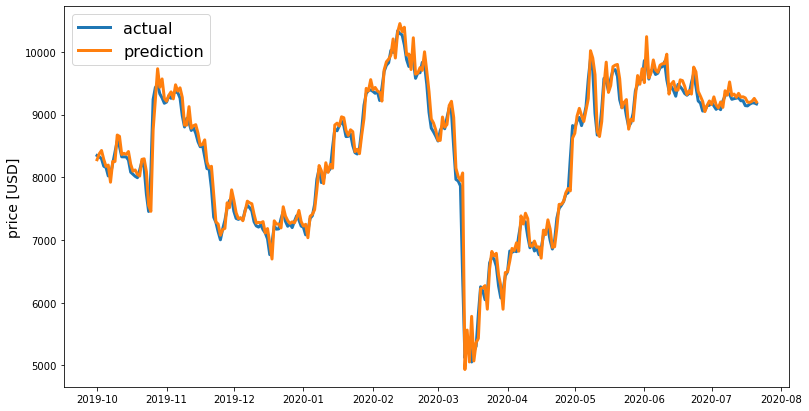

In [32]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)